<a href="https://colab.research.google.com/github/JamesIorio/Flow-Matching/blob/main/CFM_Image_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Imports and Installations

2. Model Architecture

3. Load Dataset

4. Test

5. Initialize Model & CFM

6. Training Loop

7. Visualization

In [15]:
# 1. Imports and Intsallations
# Install Packages:
!pip install torchdiffeq
!pip install torchcfm
!pip install torchdyn

# Basic Imports:
import os # Used for filesystem operations like saving modules or creating folders
import torch # Import PyTorch
import torch.nn as nn # For layers like Conv2d or linear
import torch.nn.functional as F
import torch.optim as optim # For optimizers like Adam or SGD

# Dataset and Visualization Imports:
from torchvision import datasets, transforms # To access MNIST
from torch.utils.data import DataLoader # For resizing, normalizing, and converting images to tensor
from torchvision.utils import make_grid # To put images into a grid
import matplotlib.pyplot as plt # Used for plotting images
from tqdm.auto import tqdm  # For training progress bars

#CFM Imports:
from torchcfm.conditional_flow_matching import ConditionalFlowMatcher
from torchcfm.models.unet import UNetModel # network architecture to predict velocity field

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.benchmark = True  # Good for fixed-size image generation

print("Using device:", device)
print("Torch version:", torch.__version__)

Using device: cuda
Torch version: 2.9.0+cu126


In [16]:
# 2. Model Architecture
class MLP(nn.Module):
    def __init__(self, img_size=28, hidden=512, num_classes=10, class_cond=True, time_emb_dim=64):
        super().__init__()
        self.img_size = img_size

        self.flat_dim = img_size * img_size

        self.class_cond = class_cond

        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        if class_cond:
            self.class_emb = nn.Embedding(num_classes, 32)
            cond_dim = 32
        else:
            cond_dim = 0

        # ----- Main MLP -----
        total_in = self.flat_dim + time_emb_dim + cond_dim

        layers = []
        layers.append(nn.Linear(total_in, hidden))
        layers.append(nn.SiLU())
        layers.append(nn.LayerNorm(hidden))

        for _ in range(5):
            layers.append(nn.Linear(hidden, hidden))
            layers.append(nn.SiLU())
            layers.append(nn.LayerNorm(hidden))

        layers.append(nn.Linear(hidden, self.flat_dim))

        self.mlp = nn.Sequential(*layers)

    def forward(self, t, x, y=None):
        '''
        Args:
          t: (bs,1)
          x: (bs,flat_img)
          y: (bs,1)
        Output:

        '''
        batch = x.size(0)

        t_emb = self.time_mlp(t)

        # class conditioning
        if self.class_cond:
            if y is None:
                y = torch.zeros(batch, dtype=torch.long, device=x.device)
            y_emb = self.class_emb(y)
            cond = torch.cat([x,t_emb, y_emb], dim=1)
        else:
            cond = torch.cat([x,t_emb], dim=1)
        # process each row separately
        v = self.mlp(cond)

        return v

In [17]:
# 3. Load MNIST Dataset
batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))
])
trainset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2, pin_memory=True)

print("MNIST loaded. Shape examples:")
x, y = next(iter(train_loader))
print("Image batch:", x.shape, "Labels:", y.shape)

MNIST loaded. Shape examples:
Image batch: torch.Size([64, 1, 28, 28]) Labels: torch.Size([64])


torch.Size([64, 1, 28, 28])


Text(0.5, 1.0, 'Number 9')

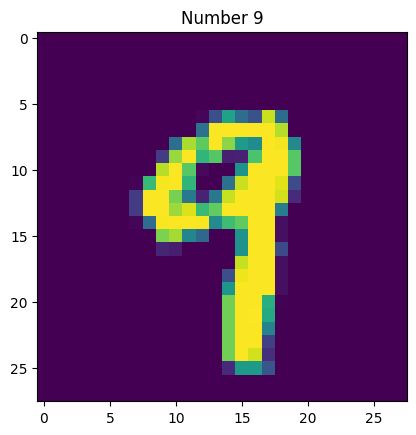

In [18]:
# 4. Test
data = iter(train_loader)
x0,y = next(data)
print(x0.shape)

example = x0[0]

plt.imshow(example.reshape(28,28))
plt.title(f'Number {y[0]}')

In [19]:
# 5. Initialize Model & CFM
model = MLP(img_size=28, hidden=512, num_classes=10, class_cond=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scaler = torch.amp.GradScaler()
FM = ConditionalFlowMatcher(sigma=0.1)
print("Model, optimizer, and CFM matcher initialized.")

Model, optimizer, and CFM matcher initialized.


Epoch 1/10  Loss: 1030.8346


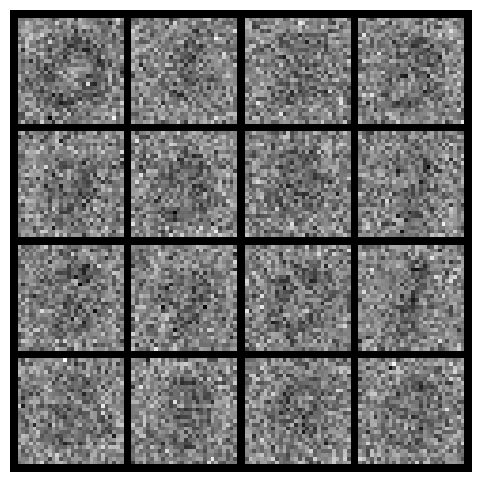

Epoch 2/10  Loss: 970.8302


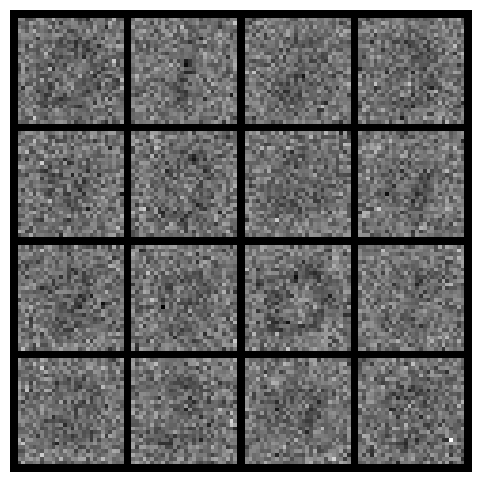

Epoch 3/10  Loss: 931.1652


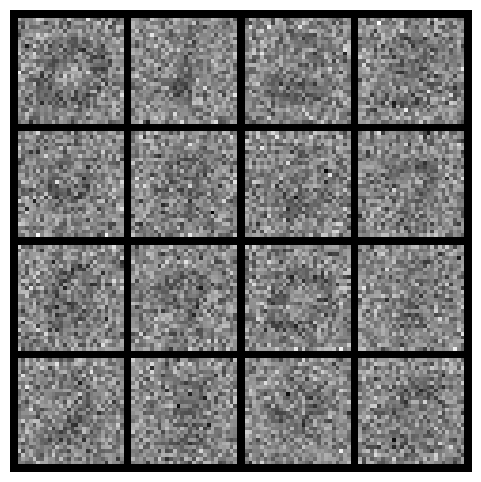

Epoch 4/10  Loss: 904.2046


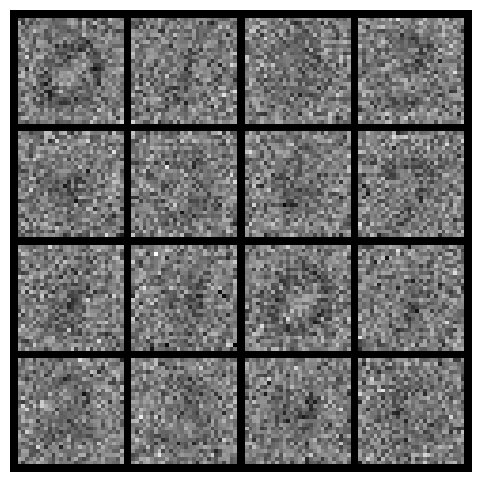

Epoch 5/10  Loss: 884.5954


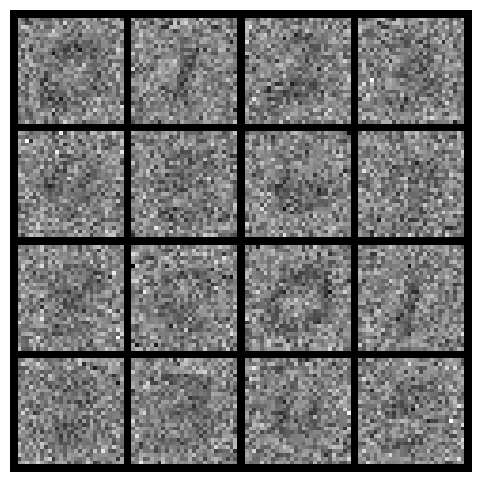

Epoch 6/10  Loss: 869.2207


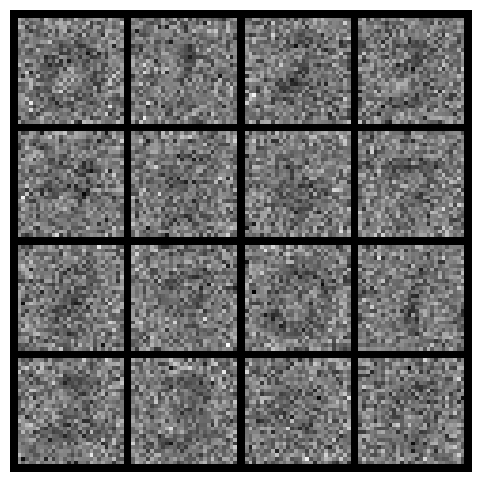

Epoch 7/10  Loss: 856.2293


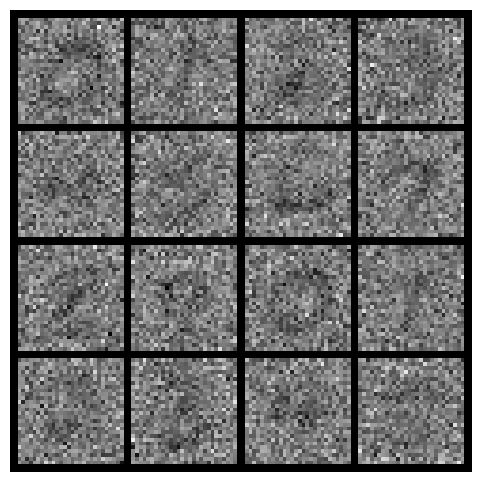

Epoch 8/10  Loss: 846.1864


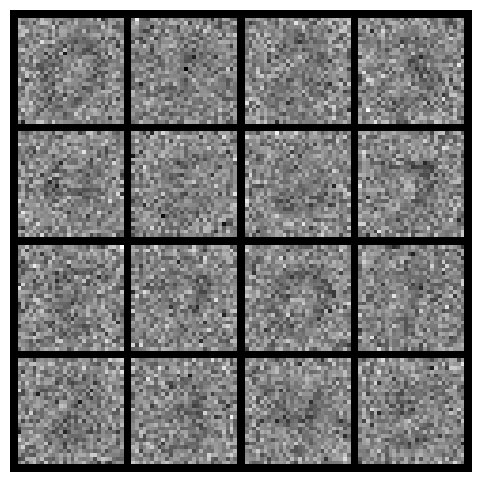

Epoch 9/10  Loss: 838.4316


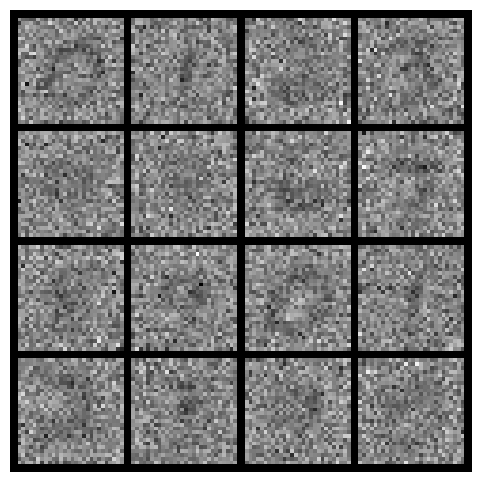

Epoch 10/10  Loss: 831.0081


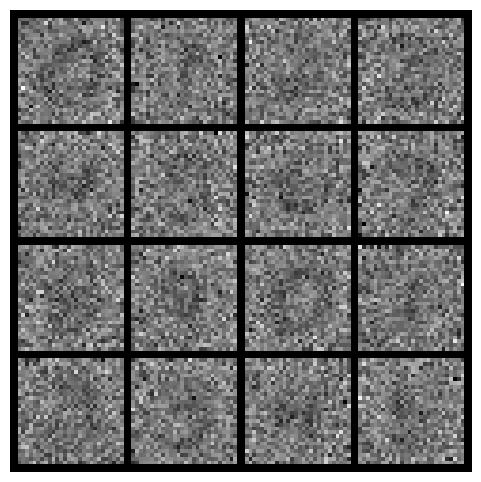

In [22]:
# 6. Training Loop
num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0.0

    for x0, y in train_loader:
        optimizer.zero_grad()
        x0 = x0.to(device)
        y  = y.to(device)

        # sample target from Gaussian noise
        x1 = torch.randn_like(x0)

        # sample random time t [0,1]
        t = torch.rand(x0.size(0), device=device)

        # Compute CFM flow (returns t_out, x_t, v_t)
        t_out, x_t, v_t = FM.sample_location_and_conditional_flow(x0, x1, t)

        # Model prediction
        x_t = x_t.view(x_t.size(0), -1)
        v_t = v_t.view(v_t.size(0), -1)
        t_out = t_out.view(x_t.size(0), 1)  # ensure (B,1)
        v_hat = model(t_out, x_t, y) # (B,784)
        # Loss & backward pass
        loss = F.mse_loss(v_hat, v_t)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}  Loss: {total_loss:.4f}")
    # Generate 16 MNIST digits
    grid = generate_grid(model, FM, device, num_samples=16, steps=50)

    # Show the grid
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1,2,0).cpu())
    plt.axis('off')
    plt.show()

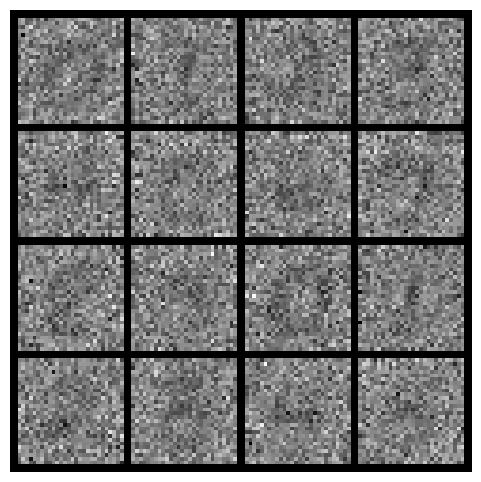

In [23]:
# 7. Visualization

def generate_grid(model, FM, device, num_samples=16, steps=50):
    # Start from Gaussian noise in image shape
    x = torch.randn(num_samples, 28*28, device=device)
    labels = torch.arange(num_samples) % 10
    y = labels.to(device)

    # Euler integration
    for step in range(steps):
        t = torch.full((num_samples,1), step/steps, device=device)
        v = model(t, x, y) # (B,784) output
        x = x + v / steps

    # reshape to (B,1,28,28) for visualization
    x_img = x.view(num_samples,28,28).unsqueeze(1) # (B,1,28,28)
    grid = make_grid(x_img, nrow=4, normalize=True)
    return grid

# Generate 16 MNIST digits
grid = generate_grid(model, FM, device, num_samples=16, steps=50)

# Show the grid
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0).cpu())
plt.axis('off')
plt.show()